In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit
import exoplanet as xo


# We need to look at the data:

- the original 6day period
- the new ~1d eclipse period
- the 1.7d mysterious signal

In [ ]:
file1 = 'tess2019306063752-s0018-0000000326815804-0162-s_lc.fits'
tablel = Table.read(file1, format='fits')
file2 = 'tess2020106103520-s0024-0000000326815804-0180-s_lc.fits'
table2 = Table.read(file2, format='fits')

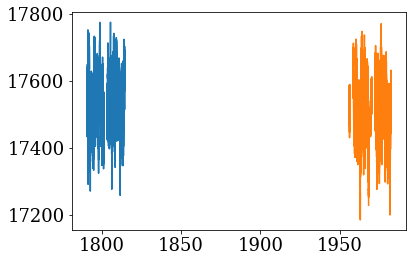

In [ ]:
plt.plot(table1['TIME'],table1['PDCSAP_FLUX'])
plt.plot(table2['TIME'],table2['PDCSAP_FLUX'])

In [ ]:
dataframe1=table1.to_pandas()
checker1=np.where(np.isfinite(dataframe['PDCSAP_FLUX']) & (dataframe['QUALITY']==0))[0]

dataframe2=table2.to_pandas()
checker2=np.where(np.isfinite(dataframe2['PDCSAP_FLUX']) & (dataframe2['QUALITY']==0))[0]

In [ ]:
original_period = 6.005 # previously published

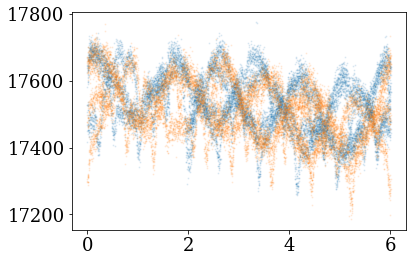

In [ ]:
plt.scatter(dataframe['TIME'].values[checker1] % original_period, dataframe['PDCSAP_FLUX'].values[checker1], alpha=0.1, s=1)
plt.scatter(dataframe2['TIME'].values[checker2] % original_period, dataframe2['PDCSAP_FLUX'].values[checker2], alpha=0.1, s=1)

In [ ]:
time_all=np.hstack((dataframe['TIME'].values[checker1],dataframe2['TIME'].values[checker2]))
flux_all=np.hstack((dataframe['PDCSAP_FLUX'].values[checker1],dataframe2['PDCSAP_FLUX'].values[checker2]))

In [ ]:
f1,p1=xo.estimators.LombScargle(dataframe['TIME'].values[checker1], dataframe['PDCSAP_FLUX'].values[checker1]).autopower()
f2,p2=xo.estimators.LombScargle(dataframe2['TIME'].values[checker2], dataframe2['PDCSAP_FLUX'].values[checker2]).autopower()

frequency,power=xo.estimators.LombScargle(time_all, flux_all).autopower() #determine the power

In [ ]:
#This is the new dominant power in the system, coming from starspots?
new_period = 1./frequency[np.argmax(power)]
print(new_period)

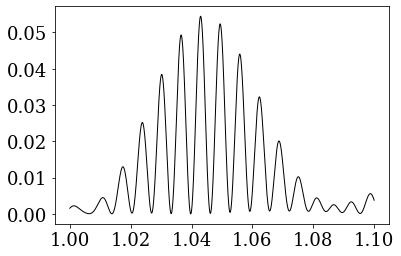

In [ ]:
supplemental_frequency=1/np.arange(1, 1.1, 0.00001)
supplemental_power=xo.estimators.LombScargle(time_all,flux_all).power(supplemental_frequency)

plt.plot(1./supplemental_frequency,supplemental_power,lw=1,c='k')
plt.plot(1./f1,p1,lw=2,label='Sector 18')
plt.plot(1./f2,p2,lw=2,label='Sector 24')
plt.plot(1./supplemental_frequency, supplemental_power, lw=1, c='k', label='Combined')
period_p = 1./supplemental_frequency[np.argmax(supplemental_power)]
plt.plot([period_p, period_p], [0,0.1], c='r', alpha=0.75)
plt.xlim(1,1.1)
plt.ylim(0,0.1)
plt.xlabel('Period (d)')
plt.ylabel('L-S Power')
plt.legend(fontsize=14)
print(period_p)

Text(0.5, 0, 'Phase (P=1.04298d)')

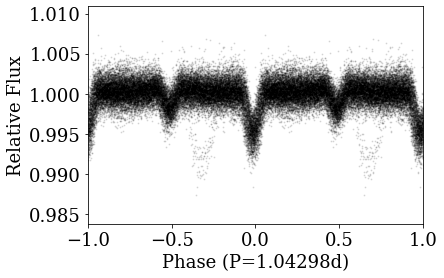

In [ ]:
semimajororbit = np.hstack((dataframe['PDCSAP_FLUX'][checker1].rolling(350, center=True).median(), 
                 dataframe2['PDCSAP_FLUX'][checker2].rolling(350, center=True).median()))

plt.scatter((time_all % period_p) / period_p, 
            (flux_all - semimajororbit)/np.nanmedian(flux_all) + 1, alpha=0.1, s=1, c='k')
plt.scatter((time_all % period_p) / period_p - 1,
            (flux_all - semimajororbit)/np.nanmedian(flux_all) + 1, alpha=0.1, s=1, c='k')

plt.xlim(-1,1)
plt.ylabel('Relative Flux')
plt.xlabel('Phase (P=1.04298d)')
# plt.savefig('EB.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

#Where is this data coming from? A background star? Starspots? We can't tell
New data capturing from APO

In [ ]:
def _gaus(x, a, b, x0, sigma):
    """
    Simple Gaussian function
    Parameters
    ----------
    x : float or 1-d numpy array
        The data to evaluate the Gaussian over
    a : float
        the amplitude
    b : float
        the constant offset
    x0 : float
        the center of the Gaussian
    sigma : float
        the width of the Gaussian
    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b

## Characterize the Eclipse
We got a better eclipse period above, now get rough durations and ephemeris

0.125
-0.01842309151181113


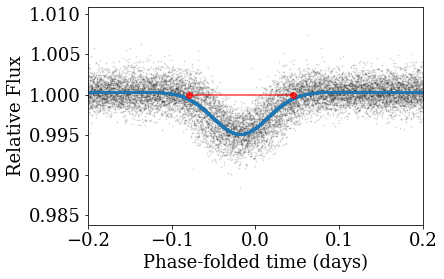

In [ ]:
plt.scatter((time_all % period_p), 
            (flux_all - semimajororbit)/np.nanmedian(flux_all) + 1, alpha=0.1, s=1, c='k')
plt.scatter((time_all % period_p) - period_p,
            (flux_all - semimajororbit)/np.nanmedian(flux_all) + 1, alpha=0.1, s=1, c='k')

plt.xlim(-.2,.2)
plt.ylabel('Relative Flux')
plt.xlabel('Phase-folded time (days)')

# measuring things by-hand...
plt.plot([-0.08, 0.045], [1,1], 'ro-', alpha=0.75)

Edur = 0.045 + 0.08 # days
print(Edur)

p0 = [-0.01, 1, 0., 0.03]
xx = np.hstack(((time_all % period_p), (time_all % period_p) - period_p))
yy = np.hstack(((flux_all - semimajororbit)/np.nanmedian(flux_all) + 1, (flux_all - semimajororbit)/np.nanmedian(flux_all) + 1))
xxd = np.where((xx > -0.2) & (xx < 0.2) & np.isfinite(xx) & np.isfinite(yy))[0]
popt, pcov = curve_fit(_gaus, xx[xxd], yy[xxd], p0=p0) 

plt.scatter(xx, _gaus(xx, *popt), s=2, alpha=0.5)

E0 = popt[2]
print(E0)

(1976, 1983)

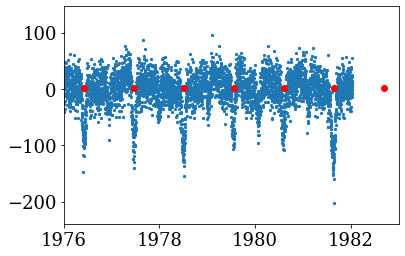

In [ ]:
#lombscargle looks okay
plt.scatter(time_all, flux_all - semimajororbit, s=5)
plt.scatter(np.arange(10000) * period_p + E0, np.ones(10000), c='r')
plt.xlim(1976,1983)

In [ ]:
#astroplan tutorial
from astropy.time import Time
import astropy.units as u
from astroplan import EclipsingSystem

primary_eclipse_time = Time(E0 + 2457000., format='jd')
orbital_period = period_p * u.day
eclipse_duration = Edur * u.day

QXcas = EclipsingSystem(primary_eclipse_time = primary_eclipse_time,orbital_period = orbital_period, duration = eclipse_duration,name='QX Cas')
orbital_period.to('hr')

In [ ]:
observing_time = Time('2022-11-05 00:00')
QXcas.next_primary_eclipse_time(observing_time, number_of_eclipses=5)

<Time object: scale='utc' format='iso' value=['2020-10-02 00:45:48.709' '2020-10-03 01:47:42.181'
 '2020-10-04 02:49:35.653' '2020-10-05 03:51:29.125'
 '2020-10-06 04:53:22.597']>

In [ ]:
from astroplan import FixedTarget, Observer, EclipsingSystem
apo = Observer.at_site('APO', timezone='US/East')
target = FixedTarget.from_name("QX Cas")
target

<FixedTarget "QX Cas" at SkyCoord (ICRS): (ra, dec) in deg (359.67984223, 61.16099259)>

In [ ]:
from astroplan import PrimaryEclipseConstraint, is_event_observable, AtNightConstraint, AltitudeConstraint, LocalTimeConstraint
import datetime as dt

number_of_transits = 350  # This is the roughly number of transits per year
observation_time = Time('2022-11-15 12:00')
midtransit_times = QXcas.next_primary_eclipse_time(observation_time, number_of_eclipses=number_of_transits)

min_local_time = dt.time(22, 0)
max_local_time = dt.time(8, 0)

constraints = [AtNightConstraint.twilight_civil(),
               AltitudeConstraint(min=30*u.deg),
               LocalTimeConstraint(min=min_local_time, max=max_local_time)]

isobs = is_event_observable(constraints, apo, target, times=midtransit_times)

gdtimes = midtransit_times[np.where(isobs[0])[0]]
for k in range(len(gdtimes)):
    print(k, gdtimes[k])


#Three period characterization

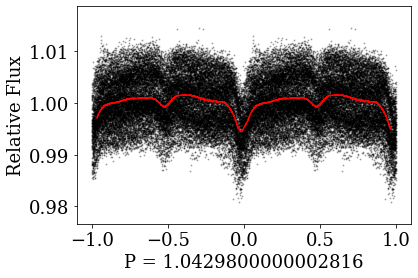

In [ ]:
plt.plot(1./frequency, power, lw=2, c='k')

plt.xlim(0, 15)
plt.ylim(0,0.7)
plt.xlabel('Period (d)')
plt.ylabel('L-S Power')

plt.plot([period_p, period_p], [0.1,0.2], c='C1', label='New Eclipse (1.04d)')
plt.plot([new_period, new_period], [0.55,0.65], c='C2', label='New Starspots (P=1.7d)')
plt.plot([original_period, original_period], [0.2,0.3], c='C3', label='Original EB Period')

plt.legend(fontsize=14)
plt.savefig('periodogram.png', dpi=150, bbox_inches='tight', pad_inches=0.25)
phz1 = np.hstack(((time_all % period_p)/period_p-1, (time_all % period_p)/period_p))
pfl1 = np.tile(flux_all/np.nanmedian(flux_all), 2)

ss1 = np.argsort(phz1)
power_semimajororbit1 = pd.Series(pfl1[ss1]).rolling(2000, center=True).median()

ind1 = np.hstack((np.arange(len(time_all)), np.arange(len(time_all))))
out1 = np.where((phz1[ss1] >= -0.5) & (phz1[ss1] < 0.5))[0]
sout1 = np.argsort(ind1[ss1][out1])

plt.scatter(phz1, pfl1, s=1, alpha=0.25, c='k')
plt.plot(phz1[ss1], power_semimajororbit1, c='r')
plt.xlabel('P = '+str(period_p))
plt.ylabel('Relative Flux')
plt.savefig('Period1.png', dpi=150, bbox_inches='tight', pad_inches=0.25)
model1 = power_semimajororbit1[out1].values[sout1] - 1
#reconstruct the time light curve
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model1+1, c='r', s=2)
plt.xlim(1790,1815)

(1790, 1815)

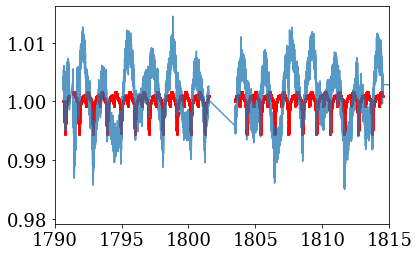

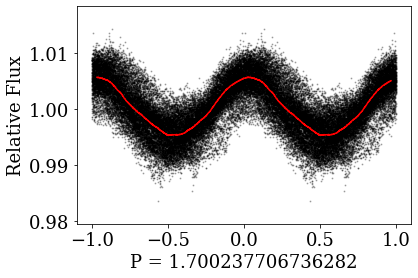

In [ ]:
phz2 = np.hstack(((time_all % new_period)/new_period-1, (time_all % new_period)/new_period))
pfl2 = np.tile(flux_all/np.nanmedian(flux_all) - model1, 2)

ss2 = np.argsort(phz2)
power_semimajororbit2 = pd.Series(pfl2[ss2]).rolling(2000, center=True).median()

ind2 = np.hstack((np.arange(len(time_all)), np.arange(len(time_all))))
out2 = np.where((phz2[ss2] >= -0.5) & (phz2[ss2] < 0.5))[0]
sout2 = np.argsort(ind2[ss2][out2])

plt.scatter(phz2, pfl2, s=1, alpha=0.25, c='k')
plt.plot(phz2[ss2], power_semimajororbit2, c='r')
plt.xlabel('P = '+str(new_period))
plt.ylabel('Relative Flux')
plt.savefig('Period2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

(1790, 1815)

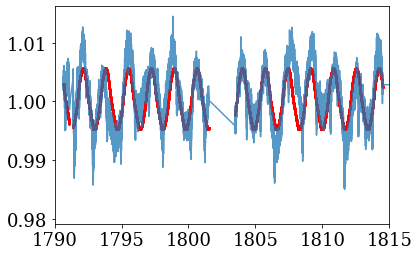

In [ ]:
model2 = power_semimajororbit2[out2].values[sout2] - 1

#second model
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model2+1, c='r', s=2)
plt.xlim(1790,1815)

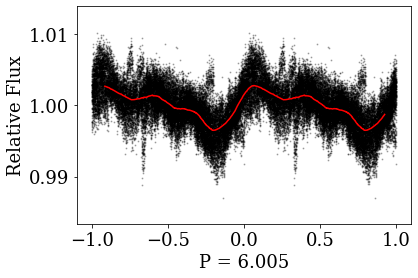

In [ ]:
phz3 = np.hstack(((time_all % original_period)/original_period-1, (time_all % original_period)/original_period))
pfl3 = np.tile(flux_all/np.nanmedian(flux_all) - model1 - model2, 2)

ss3 = np.argsort(phz3)
power_semimajororbit3 = pd.Series(pfl3[ss3]).rolling(5000, center=True).median()

ind3 = np.hstack((np.arange(len(time_all)), np.arange(len(time_all))))
out3 = np.where((phz3[ss3] >= -0.5) & (phz3[ss3] < 0.5))[0]
sout3 = np.argsort(ind3[ss3][out3])

plt.scatter(phz3, pfl3, s=1, alpha=0.25, c='k')
plt.plot(phz3[ss3], power_semimajororbit3, c='r')
plt.xlabel('P = '+str(original_period))
plt.ylabel('Relative Flux')
plt.savefig('Period3.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

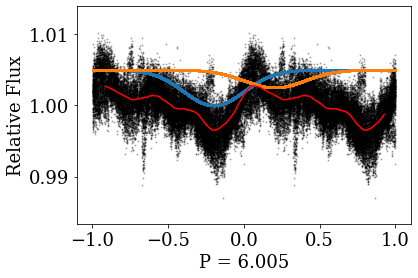

In [ ]:
plt.scatter(phz3, pfl3, s=1, alpha=0.25, c='k')
plt.plot(phz3[ss3], power_semimajororbit3, c='r')
plt.xlabel('P = '+str(original_period))
plt.ylabel('Relative Flux')

#checking old eccentricity
plt.scatter(phz3, _gaus(phz3, *(-0.005, 1.005, -0.2, 0.2)), s=2, alpha=0.5)
plt.scatter(phz3, _gaus(phz3, *(-0.0025, 1.005, -0.2 + 0.4, 0.2)), s=2, alpha=0.5)


(1790, 1815)

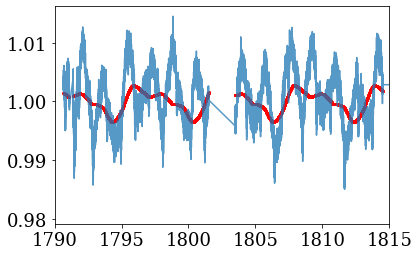

In [ ]:
model3 = power_semimajororbit3[out3].values[sout3] - 1
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model3+1, c='r', s=2)
plt.xlim(1790,1815)

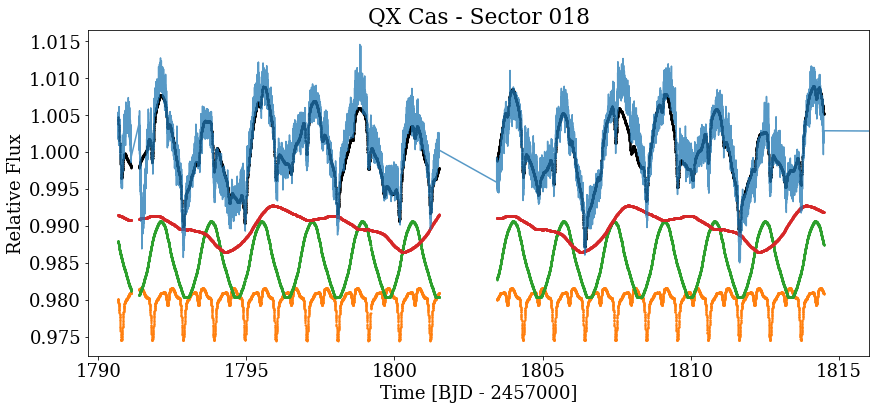

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model1 + model2 + model3+1, c='k', s=1)
plt.scatter(time_all, model1 + .98, c='C1', s=1)
plt.scatter(time_all, model2 + .985, c='C2', s=1)
plt.scatter(time_all, model3 + .99, c='C3', s=1)

plt.xlim(dataframe['TIME'].min()-1, dataframe['TIME'].max()+1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Relative Flux')
plt.title('QX Cas - Sector 018')
plt.savefig('three_period_S018.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

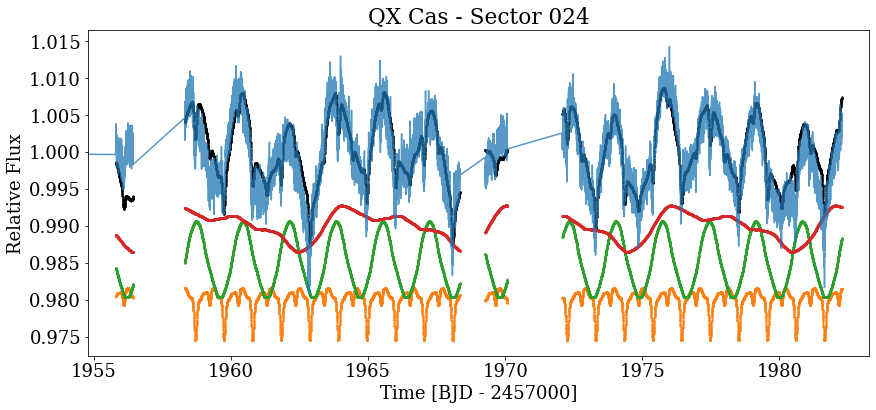

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model1 + model2 + model3+1, c='k', s=1)
plt.scatter(time_all, model1 + .98, c='C1', s=1)
plt.scatter(time_all, model2 + .985, c='C2', s=1)
plt.scatter(time_all, model3 + .99, c='C3', s=1)

plt.xlim(dataframe2['TIME'].min()-1, dataframe2['TIME'].max()+1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Relative Flux')
plt.title('QX Cas - Sector 024')
plt.savefig('three_period_S024.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

#residual checker

In [ ]:
resid = flux_all/np.nanmedian(flux_all) - (model1 + model2 + model3)
residual_frequency, residual_power = xo.estimators.LombScargle(time_all, resid).autopower()
plt.plot(1./residual_frequency, residual_power, lw=2, c='k', label='Combined')

plt.xlim(0, 15)
plt.ylim(0,0.7)
plt.xlabel('Period (d)')
plt.ylabel('L-S Power')

plt.plot([period_p, period_p], [0.2,0.3], c='C1')
plt.plot([new_period, new_period], [0.2,0.3], c='C2')
plt.plot([original_period, original_period], [0.2,0.3], c='C3')
plt.figure(figsize=(14,6))
plt.plot(time_all, flux_all/np.nanmedian(flux_all), alpha=0.75)
plt.scatter(time_all, model1 + model2 + model3+1, c='k', s=1)

plt.scatter(time_all, resid - 0.025, s=1, alpha=0.1, c='k')
plt.plot(time_all, resid*0 + 0.975, c='k', alpha=0.5)
plt.xlim(dataframe2['TIME'].min()-1, dataframe2['TIME'].max()+1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Relative Flux')
_ = plt.hist(resid, bins=100, histtype='step', lw=2)
np.std(resid)
plt.xlabel('Relative Flux Residuals')

Text(0.5, 0, 'Relative Flux Residuals')

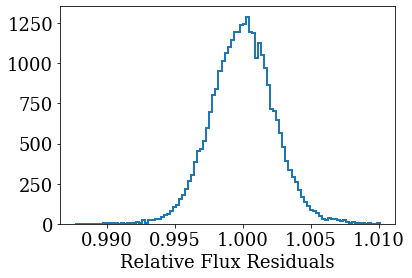

In [ ]:
np.nanmedian(dataframe['PDCSAP_FLUX_ERR']/np.nanmedian(dataframe['PDCSAP_FLUX']))

0.00113889